In [1]:
%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table

import pickle

from pyslime import slime
from pyslime import utils as pu
from pyslime.pipeline import pipelineUtils as ppu


bpDensityFile = '/Users/mwilde/Dropbox/slime-mold/data/final_data/BP_0170_densities_1024_0.bin'
bpslimedir = '/Volumes/GoogleDrive-101511024793685627081/My Drive/SlimeMold/2021-11-23-VACv2/BP_z=0.5'
bpdatafile = 'trace.bin'
out_pickle_file = '../data/mapping_BP_z0p5_1sigma.pick'

# load the BP simulation data and the BP slime data. DO NOT STANDARDIZE

In [2]:
logrhom = ppu.get_sim_data(bpDensityFile)
bpslime = pu.get_slime(bpslimedir,
                         datafile=bpdatafile,
                         dtype=np.float32,
                         standardize=False)



/Users/mwilde/python/pyslime/pyslime/utils.py:331: RuntimeWarning: divide by zero encountered in log10
  slimeobj.data = np.log10(slimeobj.data)


## Sample from both data sets randomly for sanity check

<Figure size 720x504 with 0 Axes>

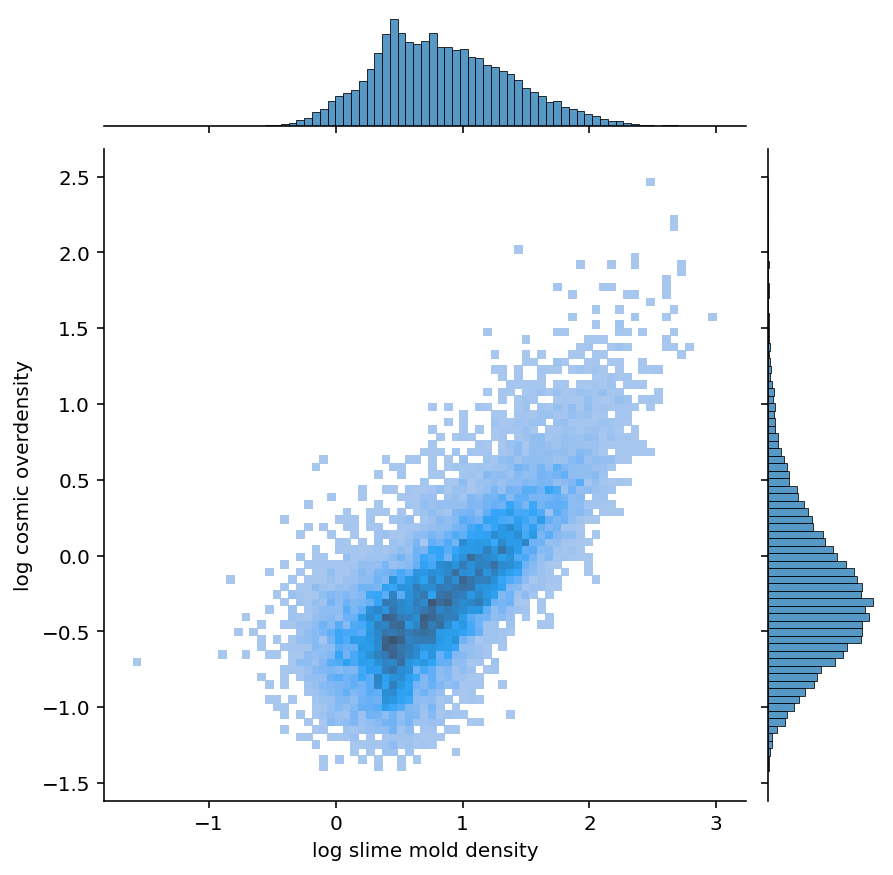

In [4]:
npts = 20000
dim = 1023
ridxs1 = np.random.randint(dim, size=npts)
ridxs2 = np.random.randint(dim, size=npts)
ridxs3 = np.random.randint(dim, size=npts)

randvals = logrhom[ridxs1,ridxs2,ridxs3]
xdist, ydist, zdist = ppu.bprho_idx_to_dist(ridxs1, ridxs2, ridxs3)
xdist = xdist/1.5
ydist = ydist/1.5
zdist = zdist/1.5

sm_dense_list = []

smdensvals = np.zeros(len(xdist))
i = 0
for i,xd in enumerate(xdist):
    smidx_x, smidx_y, smidx_z = bpslime.cartesian_to_idx(xd, ydist[i], zdist[i])
    try:
        smdensvals[i] = bpslime.data[smidx_x, smidx_y, smidx_z]
    except:
        print(xdist[i], ydist[i], zdist[i])
        print(smidx_x, smidx_y, smidx_z)
        i+=1
plt.figure(figsize=(10,7))


notinf = ~np.isinf(randvals) & ~np.isinf(smdensvals)
import seaborn as sns
g = sns.jointplot(y=randvals[notinf], x=smdensvals[notinf], kind="hist")
g.set_axis_labels(xlabel='log slime mold density', ylabel='log cosmic overdensity');

In [5]:
maxdens = bpslime.data.max( )
maxdens

3.9118638

## Sample the densites from the slime fit to the simulation and get the corresponding density from the simulation.

In [6]:
mindens = bpslime.data[~np.isinf(bpslime.data)].min() - 0.1
maxdens = bpslime.data.max( )+ 0.2 

smrhobins = np.arange(mindens,maxdens,0.1)

smrhobins = np.arange(mindens,maxdens,0.1)
bpdistribs_sm, smdistribs_sm = ppu.sample_bins(bpslime, logrhom, 
                                               smrhobins, size=20000, comoving_z=0.5)
                                               

-1.6991131067276002 0
-1.5991131067276 2415
-1.4991131067276 3346
-1.3991131067276 4514
-1.2991131067275998 6903
-1.1991131067275997 10493
-1.0991131067275997 16188
-0.9991131067275996 26661
-0.8991131067275995 45218
-0.7991131067275994 80710
-0.6991131067275993 154069
-0.5991131067275992 312608
-0.4991131067275991 670926
-0.39911310672759903 1499703
-0.29911310672759894 3352535
-0.19911310672759885 6978077
-0.09911310672759877 12237834
0.0008868932724013234 16907946
0.10088689327240141 20149405
0.2008868932724015 26608303
0.3008868932724016 38877118
0.4008868932724017 49923377
0.5008868932724018 45260180
0.6008868932724019 41257457
0.700886893272402 43512248
0.800886893272402 40920710
0.9008868932724021 38642909
1.0008868932724022 35802272
1.1008868932724023 32677818
1.2008868932724024 29231280
1.3008868932724025 25572995
1.4008868932724026 21839491
1.5008868932724027 18198762
1.6008868932724027 14765668
1.7008868932724028 11633402
1.800886893272403 8893466
1.900886893272403 6592895
2

# Find the median and 1$\sigma$ std for each slime mold density bin

In [10]:
medvals_bp, meanvals_bp, stdvals_bp, loperc_bp, hiperc_bp = ppu.distribution_stats(bpdistribs_sm)

/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
def find_xbreak(smdens, bpdens, plot=False):
    break_cut = (smdens > 0) & (smdens < 2)
    xmiddiff = 0.5*smdens[break_cut][1:] + 0.5*smdens[break_cut][:-1]
    diff = np.diff(bpdens[break_cut])
    xbreak = xmiddiff[np.argmax(diff)]
    if plot:
        plt.plot(xmiddiff, diff)
        plt.axvline(xbreak)
    return xbreak

midbins = 0.5*smrhobins[:-1]+ 0.5*smrhobins[1:]
smdens = midbins[1:-1]
bpdens = meanvals_bp[1:-1]
from scipy import stats
# find where the break is
x = np.linspace(0, 2)
xbreak = 0.8
print(xbreak)

# find what the constant y value below this break is
y_const = np.mean(bpdens[smdens < xbreak])
print(y_const)

# constrain where to do the linear fitting
lin_cut = (smdens > xbreak-0.5)

# 
xfit = smdens[lin_cut][:-2]
yfit = bpdens[lin_cut][:-2]
slope, intercept, r_value, p_value, std_err = stats.linregress(xfit, yfit)
z = np.polyfit(xfit, yfit, 3)
pfit = np.poly1d(z)

0.8
-0.5853448667398208


# Plot the mapping

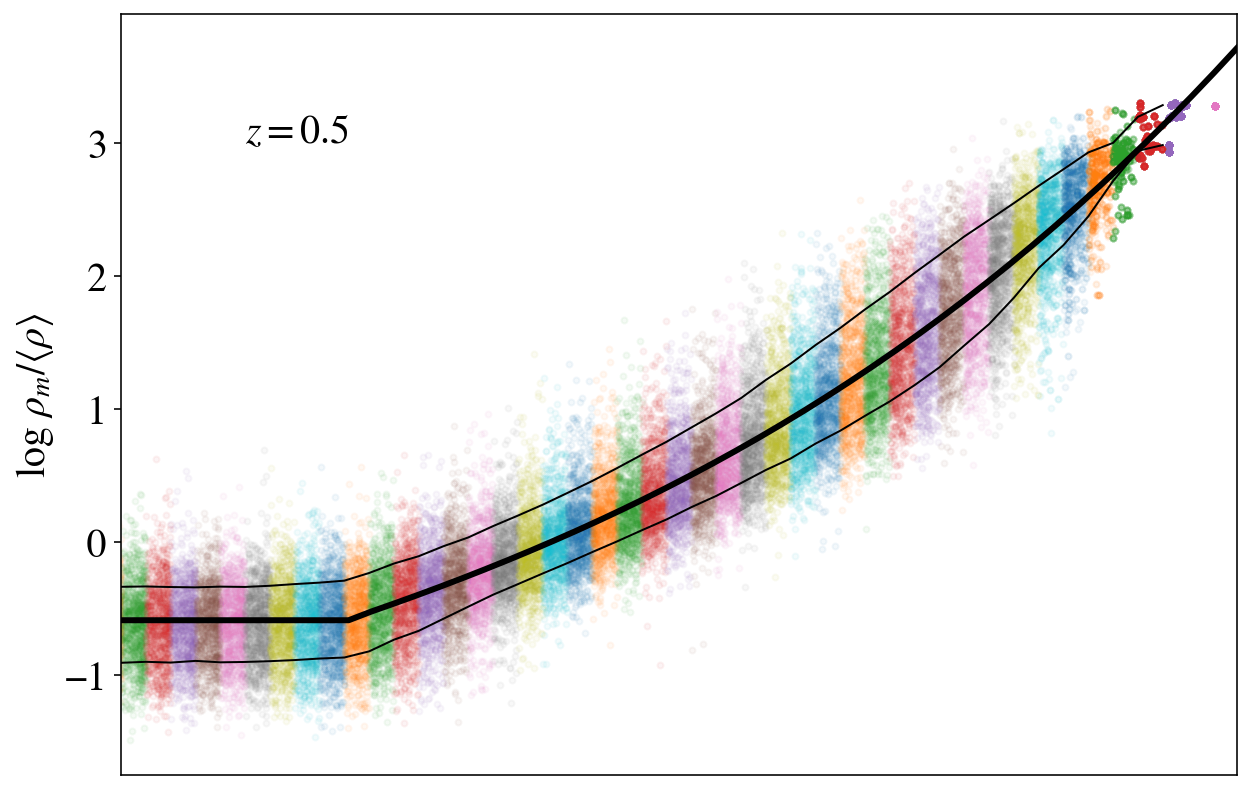

In [53]:
import matplotlib
matplotlib.rcParams['font.serif'] = "Times"
matplotlib.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 20

fig = plt.figure(figsize=(10,7))
for i in range(len(smdistribs_sm)):
    plt.plot(smdistribs_sm[i][::20], bpdistribs_sm[i][::20],'.',alpha=0.05, rasterized=True)
# plt.scatter(smrhobins[1:-4], medvals_bp[1:-3], marker='_', color='black', linewidth=3)
# plt.step(smrhobins[1:-4], medvals_bp[1:-3], where='mid', color='black', linewidth=1)
plt.plot(smrhobins[1:-4], loperc_bp[1:-3],color='black',linewidth=1)
plt.plot(smrhobins[1:-4], hiperc_bp[1:-3],color='black',linewidth=1)

xfull = np.linspace(-0.5, 4, 50)
#pipedatadir = "/Users/mwilde/python/pyslime/pyslime/pipeline/data/"
from pyslime.pipeline import interpolate, catalogs

plt.plot(xfull, interpolate.relu_p3(xfull, xbreak, y_const, pfit), lw=3, c='black')

plt.xlabel('log MCPM density')
plt.ylabel(r'log $\rho_m / \langle \rho \rangle$');
plt.text(0, 3, r'$z = 0.5$' )
plt.xlim(-0.5, 4)
plt.xlabel("")
plt.xticks([])
plt.savefig('/Users/mwilde/python/pyslime/pyslime/paper/figures/slime_mapping_z5.png', dpi=300)

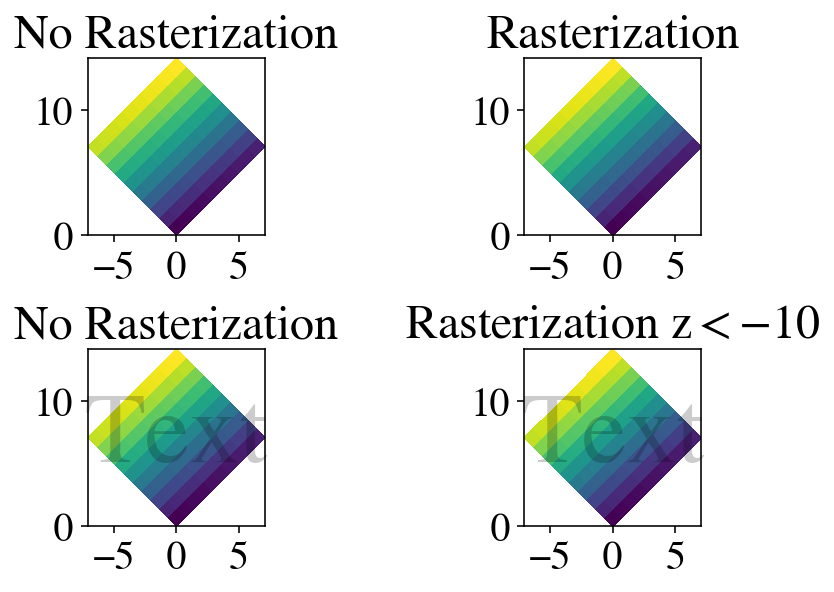

In [52]:
import numpy as np
import matplotlib.pyplot as plt

d = np.arange(100).reshape(10, 10)  # the values to be color-mapped
x, y = np.meshgrid(np.arange(11), np.arange(11))

theta = 0.25*np.pi
xx = x*np.cos(theta) - y*np.sin(theta)  # rotate x by -theta
yy = x*np.sin(theta) + y*np.cos(theta)  # rotate y by -theta

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=True)

# pcolormesh without rasterization
ax1.set_aspect(1)
ax1.pcolormesh(xx, yy, d)
ax1.set_title("No Rasterization")

# pcolormesh with rasterization; enabled by keyword argument
ax2.set_aspect(1)
ax2.set_title("Rasterization")
m = ax2.pcolormesh(xx, yy, d, rasterized=True)

# pcolormesh with an overlaid text without rasterization
ax3.set_aspect(1)
ax3.pcolormesh(xx, yy, d)
ax3.text(0.5, 0.5, "Text", alpha=0.2,
         va="center", ha="center", size=50, transform=ax3.transAxes)
ax3.set_title("No Rasterization")

# pcolormesh with an overlaid text without rasterization; enabled by zorder.
# Setting the rasterization zorder threshold to 0 and a negative zorder on the
# pcolormesh rasterizes it. All artists have a non-negative zorder by default,
# so they (e.g. the text here) are not affected.
ax4.set_aspect(1)
m = ax4.pcolormesh(xx, yy, d, zorder=-10)
ax4.text(0.5, 0.5, "Text", alpha=0.2,
         va="center", ha="center", size=50, transform=ax4.transAxes)
ax4.set_rasterization_zorder(0)
ax4.set_title("Rasterization z$<-10$")

# Save files in pdf and eps format
#plt.savefig("test_rasterization.pdf", dpi=150)
#plt.savefig("test_rasterization.eps", dpi=150)

if not plt.rcParams["text.usetex"]:
    pass
    #plt.savefig("test_rasterization.svg", dpi=150)
    # svg backend currently ignores the dpi

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
packageDict_smBins = {'medvals_bp':medvals_bp,'meanvals_bp':meanvals_bp,
              'loperc_bp':loperc_bp,'hiperc_bp':hiperc_bp,'bpdistribs_sm':bpdistribs_sm,
                      'smdistribs_sm':smdistribs_sm,'smrhobins':smrhobins}

# save the data since its so slow:

In [ ]:
pickle.dump(packageDict_smBins,open(out_pickle_file,'wb'))

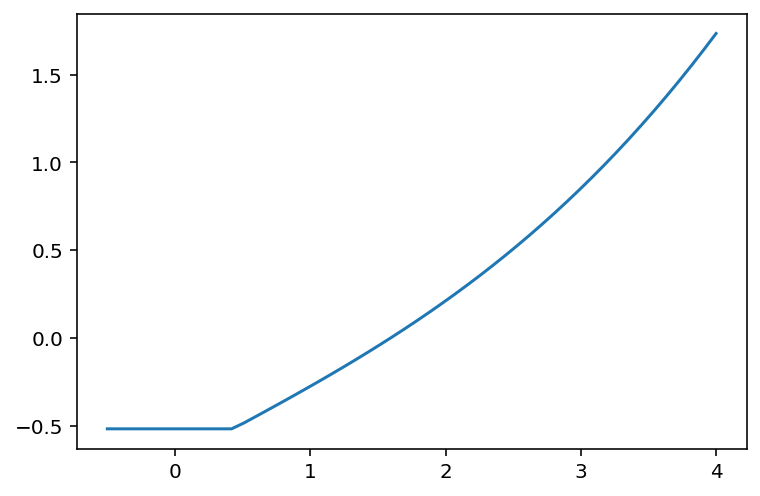

In [ ]:
# All the data live here (except the simulation binaries):
datadir = "/Volumes/GoogleDrive-101511024793685627081/My Drive/SlimeMold/2021-11-23-VACv2/"
dropboxdir = "/Users/mwilde/Dropbox/slime-mold/data/final_data/"
packagedir = "/Users/mwilde/python/pyslime/pyslime/pipeline/data/"
otherdatadir = "/Users/mwilde/python/pyslime/pyslime/data/"

### STEP 1: Compute the mapping from the BP simulation to the SlimeMold
# DM denstiy from the simulations
bpDensityFile_z0p0 = dropboxdir + "BP_0214_densities_1024_0.bin"
bpDensityFile_z0p5 = dropboxdir + "BP_0170_densities_1024_0.bin"

# slime fit to the BP simulations
bpslimedir = datadir + "BP_z=0.5"
bpslime_datafile = "trace.bin"

# this is very slow so dont run if you trust the mapping
out_pickle_file_z0p0 = packagedir + "mapping_BP_z0p0_1sigma.pick"
out_pickle_file_z0p5 = packagedir + "mapping_BP_z0p5_1sigma.pick"

In [ ]:
ppu.calc_map_bp_slime(
    bpDensityFile_z0p5, bpslimedir, bpslime_datafile, out_pickle_file_z0p5
)

/Users/mwilde/python/pyslime/pyslime/utils.py:331: RuntimeWarning: divide by zero encountered in log10
  slimeobj.data = np.log10(slimeobj.data)


-1.6991131067276002 0
-1.5991131067276 2415
-1.4991131067276 3346
-1.3991131067276 4514
-1.2991131067275998 6903
-1.1991131067275997 10493
-1.0991131067275997 16188
-0.9991131067275996 26661
-0.8991131067275995 45218
-0.7991131067275994 80710
-0.6991131067275993 154069
-0.5991131067275992 312608
-0.4991131067275991 670926
-0.39911310672759903 1499703
-0.29911310672759894 3352535
-0.19911310672759885 6978077
-0.09911310672759877 12237834
0.0008868932724013234 16907946
0.10088689327240141 20149405
0.2008868932724015 26608303
0.3008868932724016 38877118
0.4008868932724017 49923377
0.5008868932724018 45260180
0.6008868932724019 41257457
0.700886893272402 43512248
0.800886893272402 40920710
0.9008868932724021 38642909
1.0008868932724022 35802272
1.1008868932724023 32677818
1.2008868932724024 29231280
1.3008868932724025 25572995
1.4008868932724026 21839491
1.5008868932724027 18198762
1.6008868932724027 14765668
1.7008868932724028 11633402
1.800886893272403 8893466
1.900886893272403 6592895
2

/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
packagedir + "mapping_BP_z0p5_1sigma.pick"

'/Users/mwilde/python/pyslime/pyslime/pipeline/data/mapping_BP_z0p5_1sigma.pick'